In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
titanic_data = pd.read_csv('data/train.csv')

In [5]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



numeric_columnsة: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


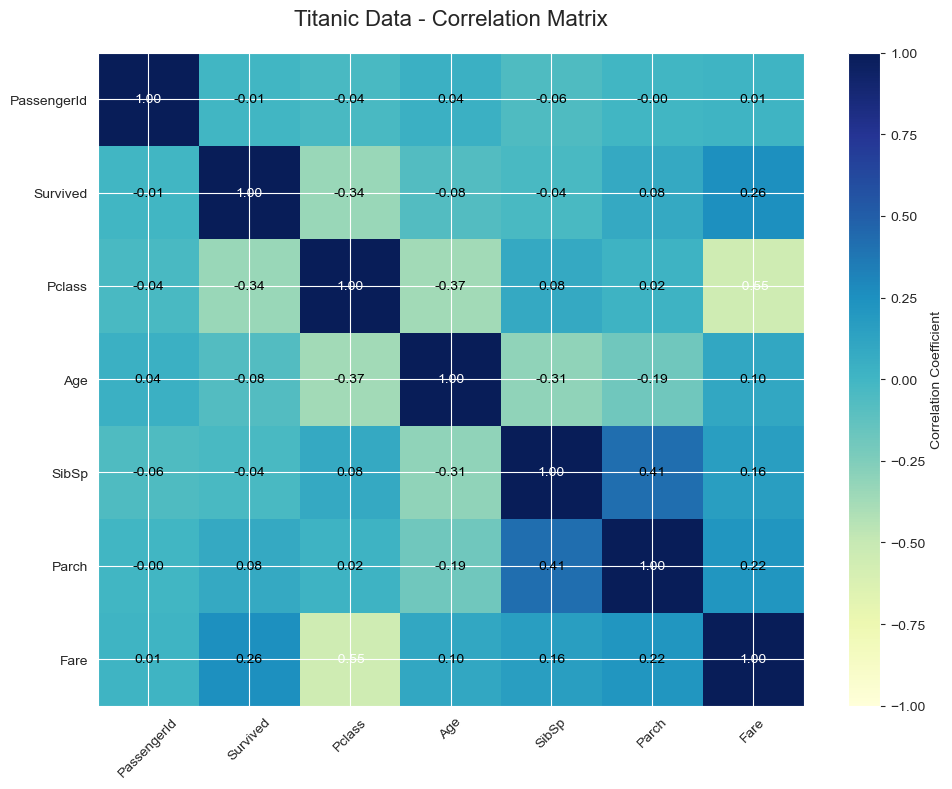

In [14]:


numeric_columns = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


print(f"\nnumeric_columnsة: {numeric_columns}")

correlation_matrix = titanic_data[numeric_columns].corr()


plt.figure(figsize=(10, 8))
im = plt.imshow(correlation_matrix, cmap='YlGnBu', aspect='auto', vmin=-1, vmax=1)


plt.colorbar(im, label='Correlation Coefficient')


plt.title('Titanic Data - Correlation Matrix', fontsize=16, pad=20)
plt.xticks(range(len(numeric_columns)), numeric_columns, rotation=45)
plt.yticks(range(len(numeric_columns)), numeric_columns)


for i in range(len(numeric_columns)):
    for j in range(len(numeric_columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', 
                color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')

plt.tight_layout()
plt.show()



In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

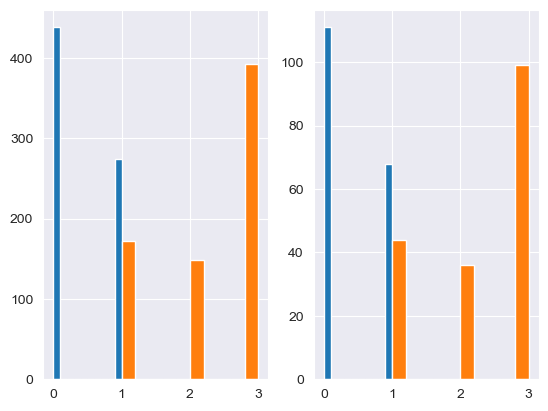

In [22]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()
plt.show()

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])  
        return X

In [24]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        
        X_copy['Embarked'] = X_copy['Embarked'].fillna('S')
        
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X_copy[['Embarked']]).toarray()
        column_names = ["C", "S", "Q"]  # C=Cherbourg, S=Southampton, Q=Queenstown
        
        for i in range(len(matrix.T)):
            X_copy[column_names[i]] = matrix.T[i]
        
        
        matrix = encoder.fit_transform(X_copy[['Sex']]).toarray()
        column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X_copy[column_names[i]] = matrix.T[i]
        
        return X_copy

In [25]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"],axis=1,errors="ignore")

In [26]:
from sklearn.pipeline import Pipeline

pipeline=Pipeline([
        ("ageImputer",AgeImputer()),
        ("featureEncoder",FeatureEncoder()),
        ("featureDropper",FeatureDropper())
])

In [27]:
strat_train_set=pipeline.fit_transform(strat_train_set)


In [28]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
774,775,1,2,54.000000,1,3,23.0000,0.0,0.0,1.0,1.0,0.0
541,542,0,3,9.000000,4,2,31.2750,0.0,0.0,1.0,1.0,0.0
635,636,1,2,28.000000,0,0,13.0000,0.0,0.0,1.0,1.0,0.0
517,518,0,3,29.333345,0,0,24.1500,0.0,1.0,0.0,0.0,1.0
205,206,0,3,2.000000,0,1,10.4625,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
856,857,1,1,45.000000,1,1,164.8667,0.0,0.0,1.0,1.0,0.0
249,250,0,2,54.000000,1,0,26.0000,0.0,0.0,1.0,0.0,1.0
211,212,1,2,35.000000,0,0,21.0000,0.0,0.0,1.0,1.0,0.0
325,326,1,1,36.000000,0,0,135.6333,1.0,0.0,0.0,1.0,0.0


In [29]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 774 to 173
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [30]:
from sklearn.preprocessing import StandardScaler


X = strat_train_set.drop(['Survived'], axis=1)  
y = strat_train_set['Survived']                

scaler=StandardScaler()
X_data=scaler.fit_transform(X)
Y_data=y.to_numpy()

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()


param_grid =[ {
    "n_estimators": [10, 100, 200, 500],  
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 3, 4]
}]


grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, Y_data)  



GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [32]:
final_clf=grid_search.best_estimator_


In [33]:
final_clf

RandomForestClassifier(max_depth=5, n_estimators=500)

In [34]:
strat_test_set=pipeline.fit_transform(strat_test_set)

In [35]:
X_test=strat_test_set.drop(['Survived'],axis=1)
Y_test=strat_test_set['Survived']

scaler=StandardScaler()
X_data_test=scaler.fit_transform(X_test)
Y_data_test=Y_test.to_numpy()

In [36]:
final_clf.score(X_data_test,Y_data_test)

0.8156424581005587

In [37]:
final_data=pipeline.fit_transform(titanic_data)

In [38]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [39]:
X_final=final_data.drop(['Survived'],axis=1)
Y_final=final_data['Survived']

scaler=StandardScaler()
X_data_final=scaler.fit_transform(X_final)
Y_data_final=Y_final.to_numpy()

In [40]:
prod_clf = RandomForestClassifier()


param_grid =[ {
    "n_estimators": [10, 100, 200, 500],  
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 3, 4]
}]


grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data_final, Y_data_final)  


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [41]:
prod_final_clf=grid_search.best_estimator_

In [42]:

titanic_test_data = pd.read_csv("data/test.csv")

In [43]:
final_test_data = pipeline.fit_transform(titanic_test_data)  


In [45]:
X_final_test = final_test_data.copy()
X_final_test = X_final_test.ffill()

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [46]:
predicitions=prod_final_clf.predict(X_data_final_test)

In [47]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predicitions
final_df.to_csv("data/predictions.csv",index=False)

In [48]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [49]:
final_df.to_csv(r"C:\Users\hp\Desktop\predictions.csv", index=False)
